In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Image Analysis

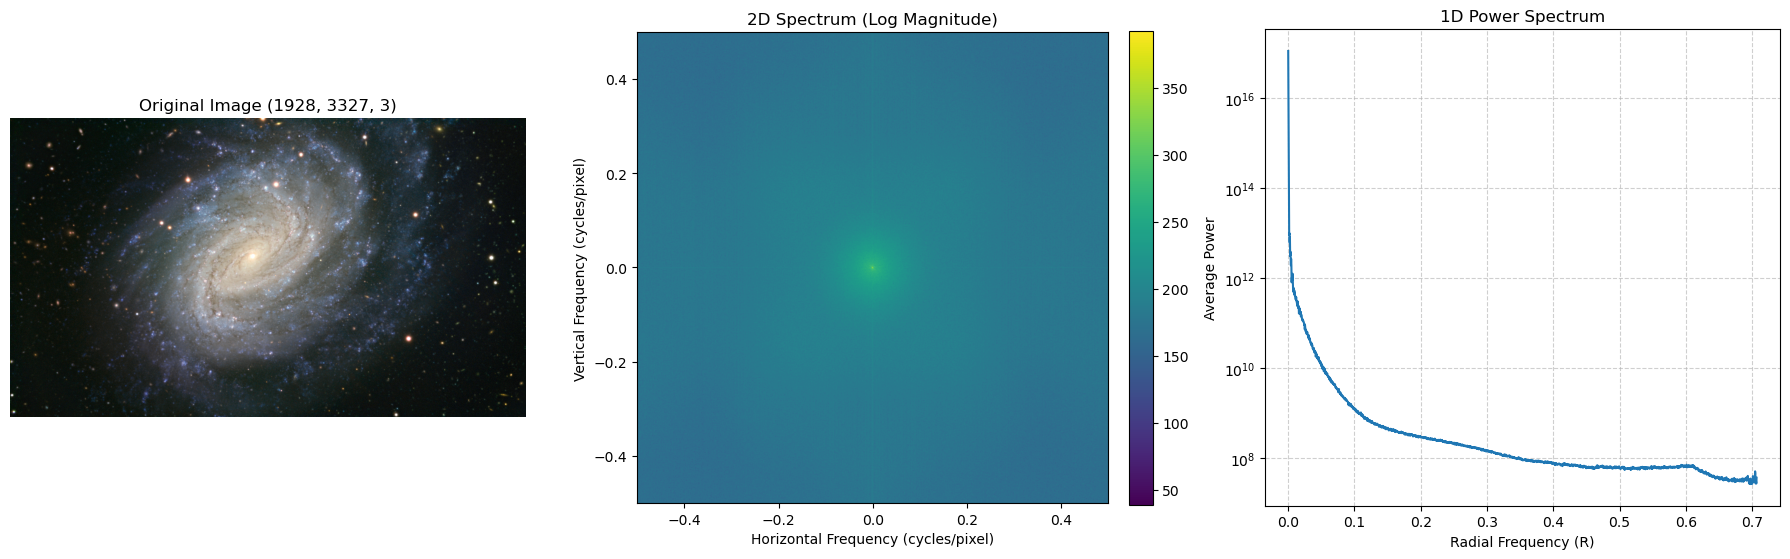

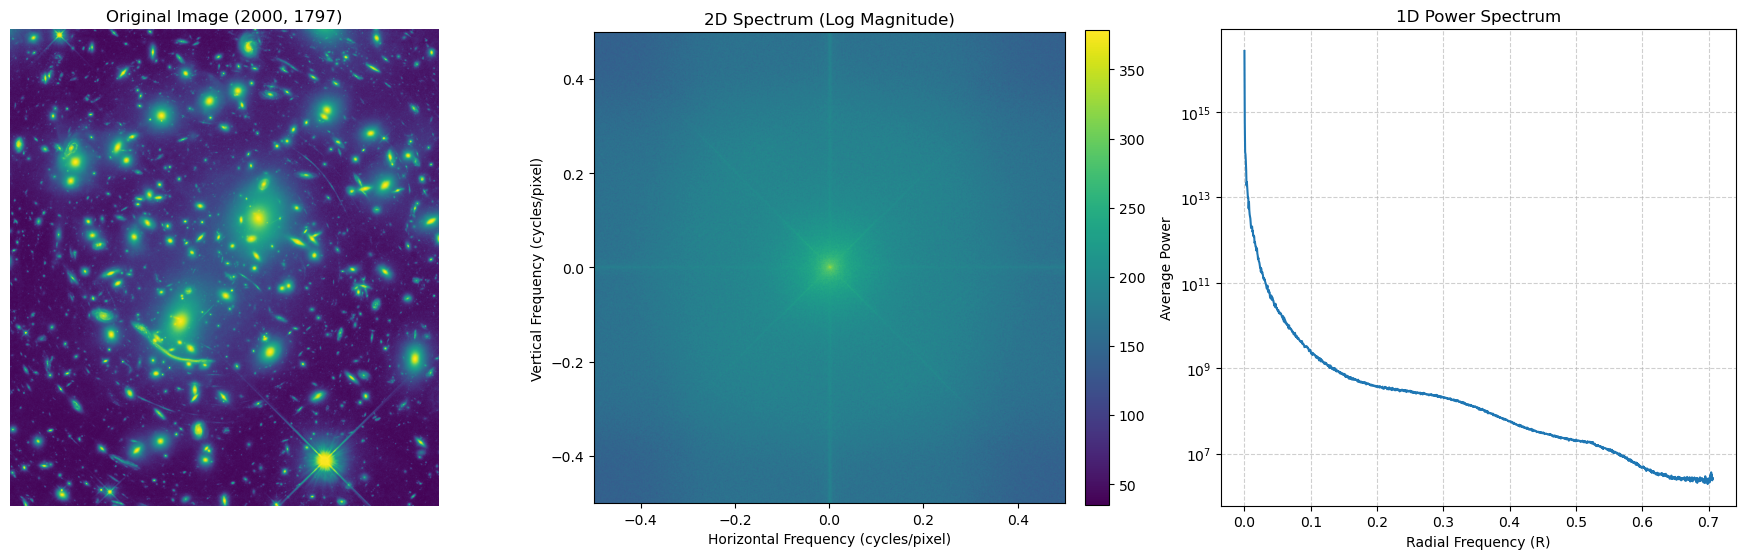

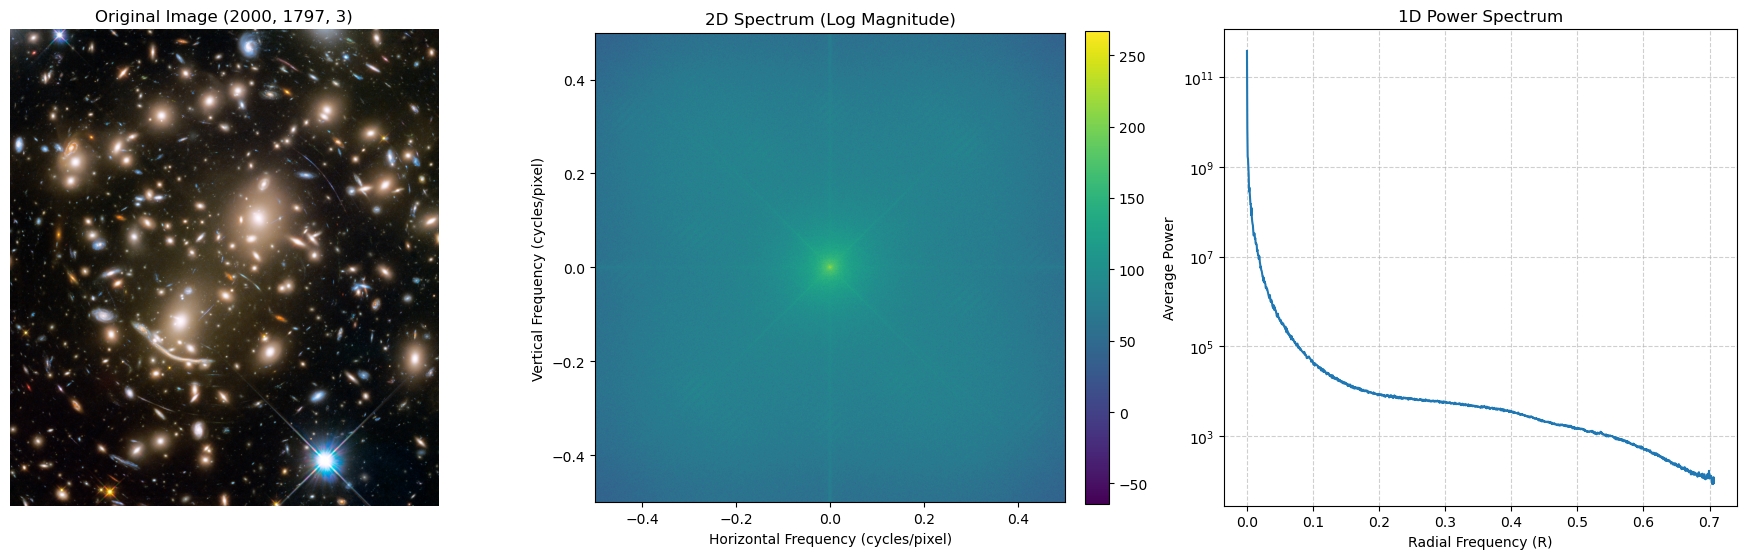

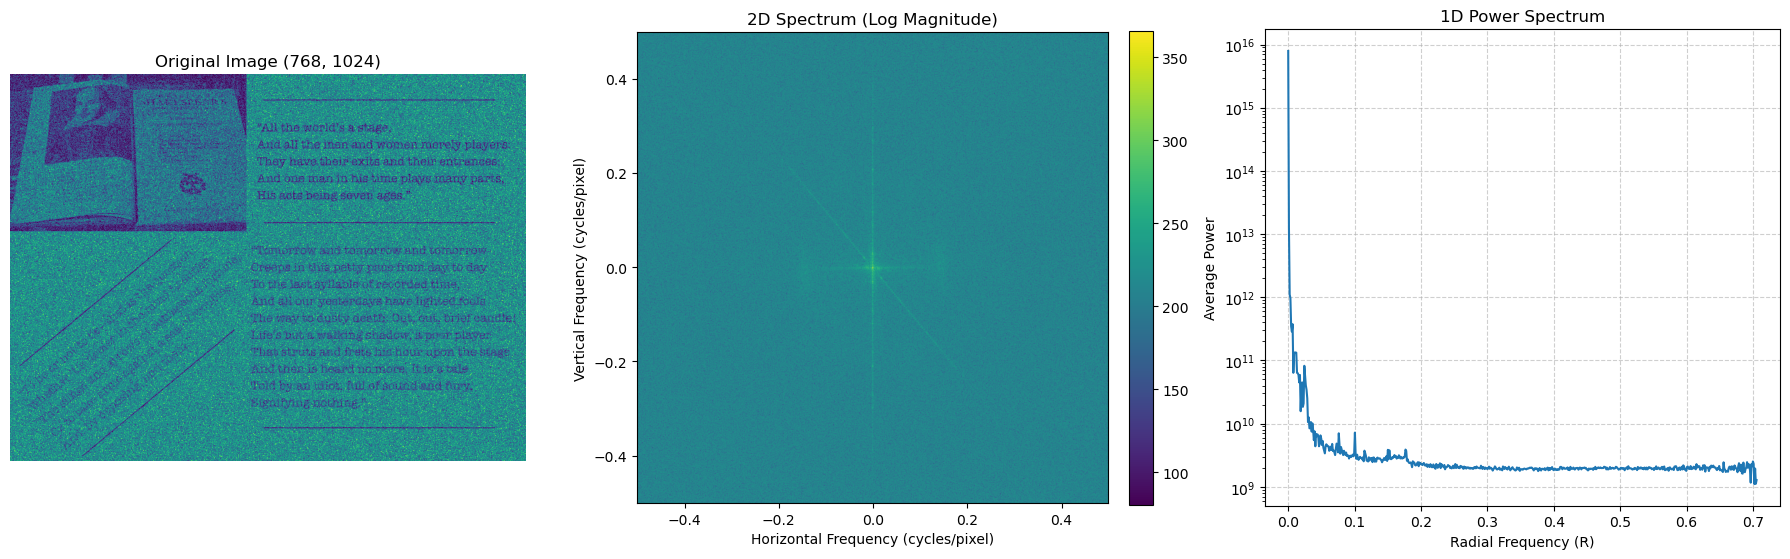

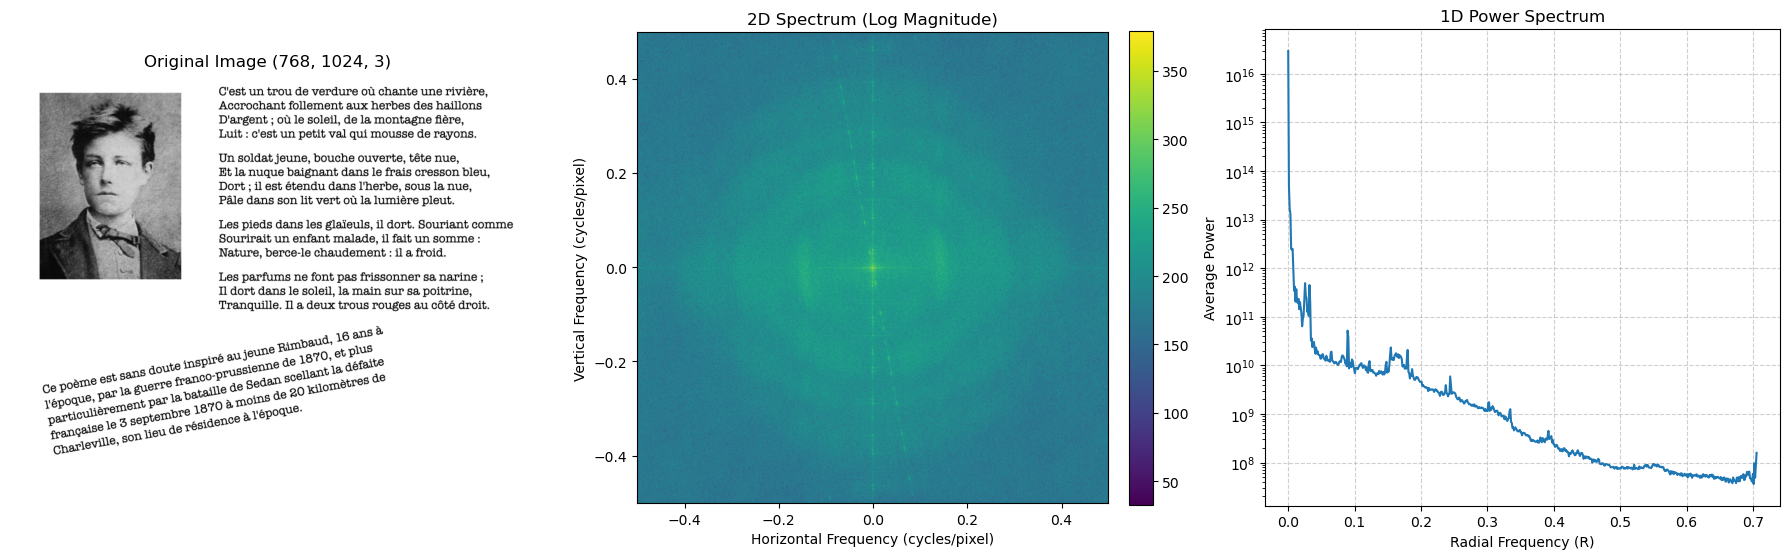

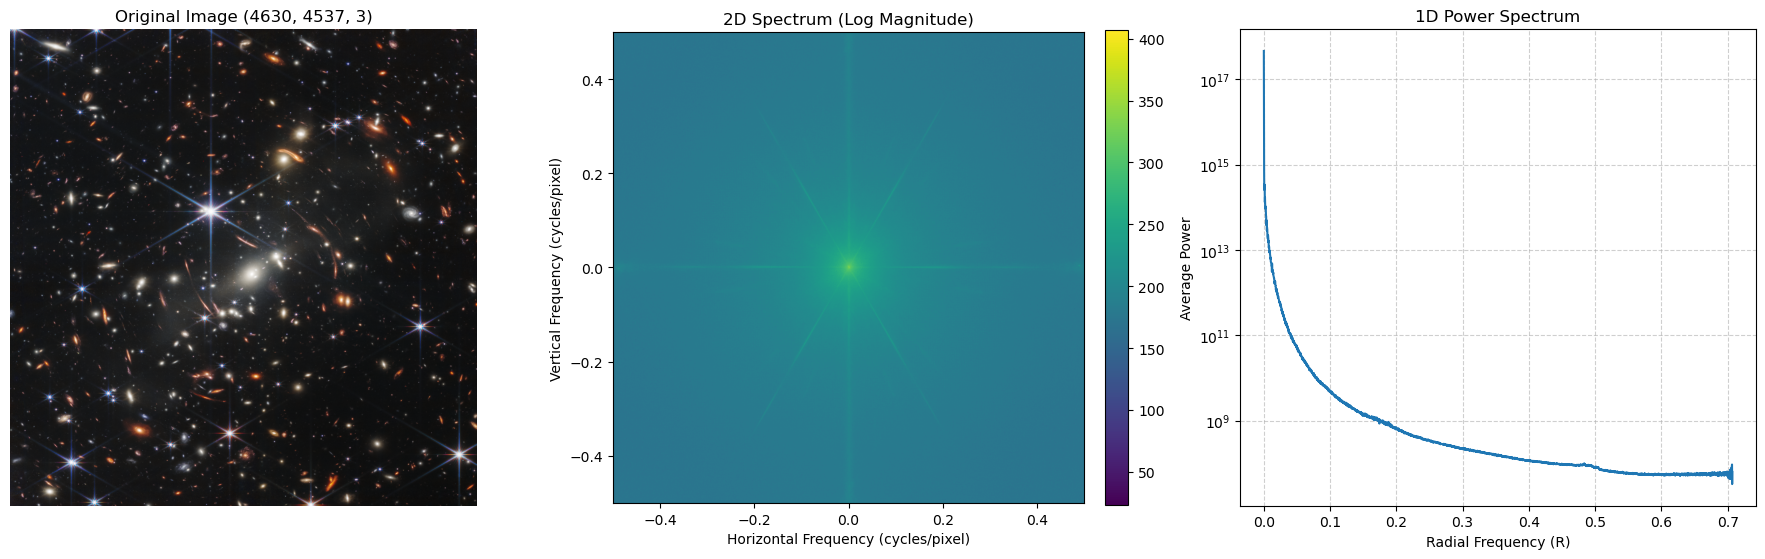

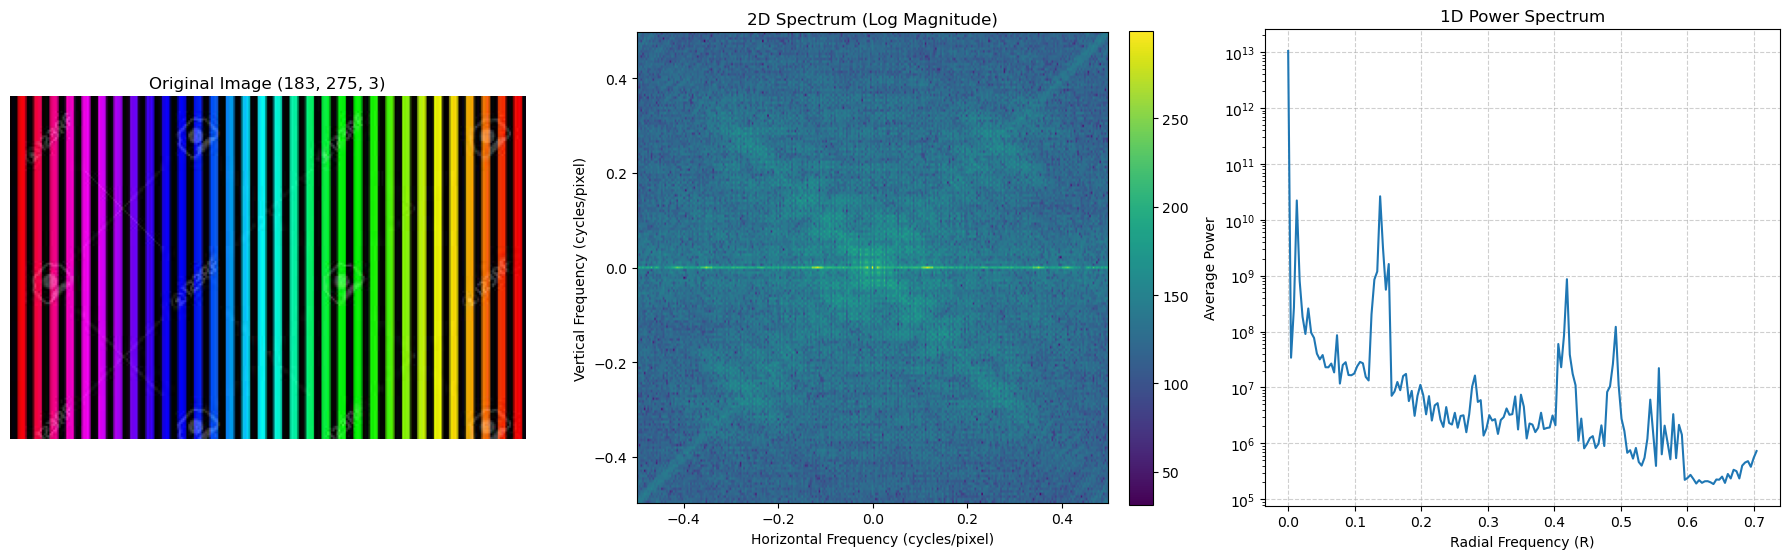

In [17]:
def PowerSpectrum1D(power_spectrum_2D):
    """
    Calculate the radial profile by averaging the power values at the same distance (radius) from the center in the 2D spectrum.
    """
    M, N = power_spectrum_2D.shape
    center_y, center_x = M // 2, N // 2
    y, x = np.indices(power_spectrum_2D.shape)
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    r_int = r.astype(int)
    
    pbin = np.bincount(r_int.ravel(), power_spectrum_2D.ravel()) # Sum Power Spectrum for each radius
    nr = np.bincount(r_int.ravel()) # Number of pixels with certain radius
    
    profile = pbin / np.where(nr == 0, 1, nr) # Compute the average (1D spectrum)
    
    max_radius = np.max(r_int)
    return profile[:max_radius]

def plot(image_path):
    """
    Load an image, calculate and plot: Original Image, 2D FFT and 1D Power Spectrum.
    """

    img = mpimg.imread(image_path) # Load image
    
    if img.ndim == 3:
        gray_img = np.mean(img[:, :, :3], axis=2) #Average value to convert image to grayscale
    elif img.ndim == 2:
        gray_img = img

    f = np.fft.fft2(gray_img) # Compute FFT of the image
    fshift = np.fft.fftshift(f) #Shift the FFT only for a better visualization
    
    power_spectrum_2D = np.abs(fshift)**2 # 2D Spectrum
    
    power_spectrum_2D_log = 20 * np.log(np.abs(fshift)) # 2D Spectrum in logarithm scale to note changes
    
    # 3. Calcular el Espectro de Potencia 1D (Perfil Radial)
    power_spectrum_1D = PowerSpectrum1D(power_spectrum_2D) # Compute 1D Power Spectrum.

    M, N = gray_img.shape # Image Dimentions

    freq_x = np.fft.fftshift(np.fft.fftfreq(N))
    freq_y = np.fft.fftshift(np.fft.fftfreq(M)) 

    
    max_radius = len(power_spectrum_1D)
    max_freq = np.sqrt(freq_x.max()**2 + freq_y.max()**2) 
    radial_freqs = np.linspace(0, max_freq, max_radius)

    # PLOTTING
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    #fig.suptitle('hsdjf', fontsize=16)

    # Plot 1: Original Image
    ax[0].imshow(img)
    ax[0].set_title(f'Original Image {img.shape}', fontsize=12)
    ax[0].axis('off')

    # Plot 2: 2D Spectrum
    im = ax[1].imshow(power_spectrum_2D_log, cmap='viridis', extent=[freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max()])
    ax[1].set_title('2D Spectrum (Log Magnitude)', fontsize=12)
    ax[1].set_xlabel('Horizontal Frequency (cycles/pixel)')
    ax[1].set_ylabel('Vertical Frequency (cycles/pixel)')
    plt.colorbar(im, ax = ax[1], fraction = 0.046, pad = 0.04)

    # Plot 3: 1D Power Spectrum
    ax[2].plot(radial_freqs, power_spectrum_1D)
    ax[2].set_title('1D Power Spectrum', fontsize=12)
    ax[2].set_xlabel('Radial Frequency (R)')
    ax[2].set_ylabel('Average Power')
    ax[2].set_yscale('log')
    ax[2].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajustar para el título principal
    plt.show()


# La función se ejecuta cargando el archivo de muestra generado
plot('Images/eso_ngc1187.jpg')
plot('Images/hst_abell370_grey.jpg')
plot('Images/hst_abell370.png')
plot('Images/img_sms_1_noisy.jpg')
plot('Images/img_sms_2.jpeg')
plot('Images/JWST_smacs0723.jpg')
plot('Images/abs.jpeg')


### Denoising

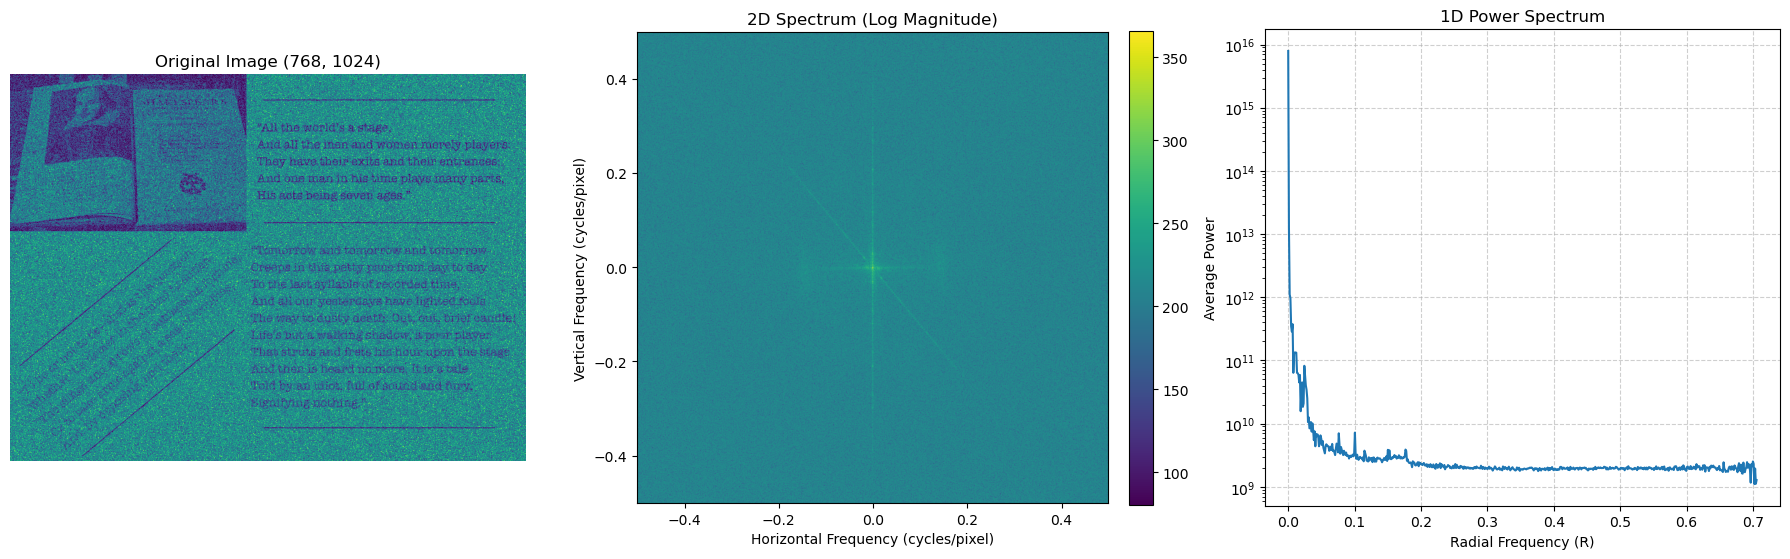

In [18]:
plot('Images/img_sms_1_noisy.jpg')

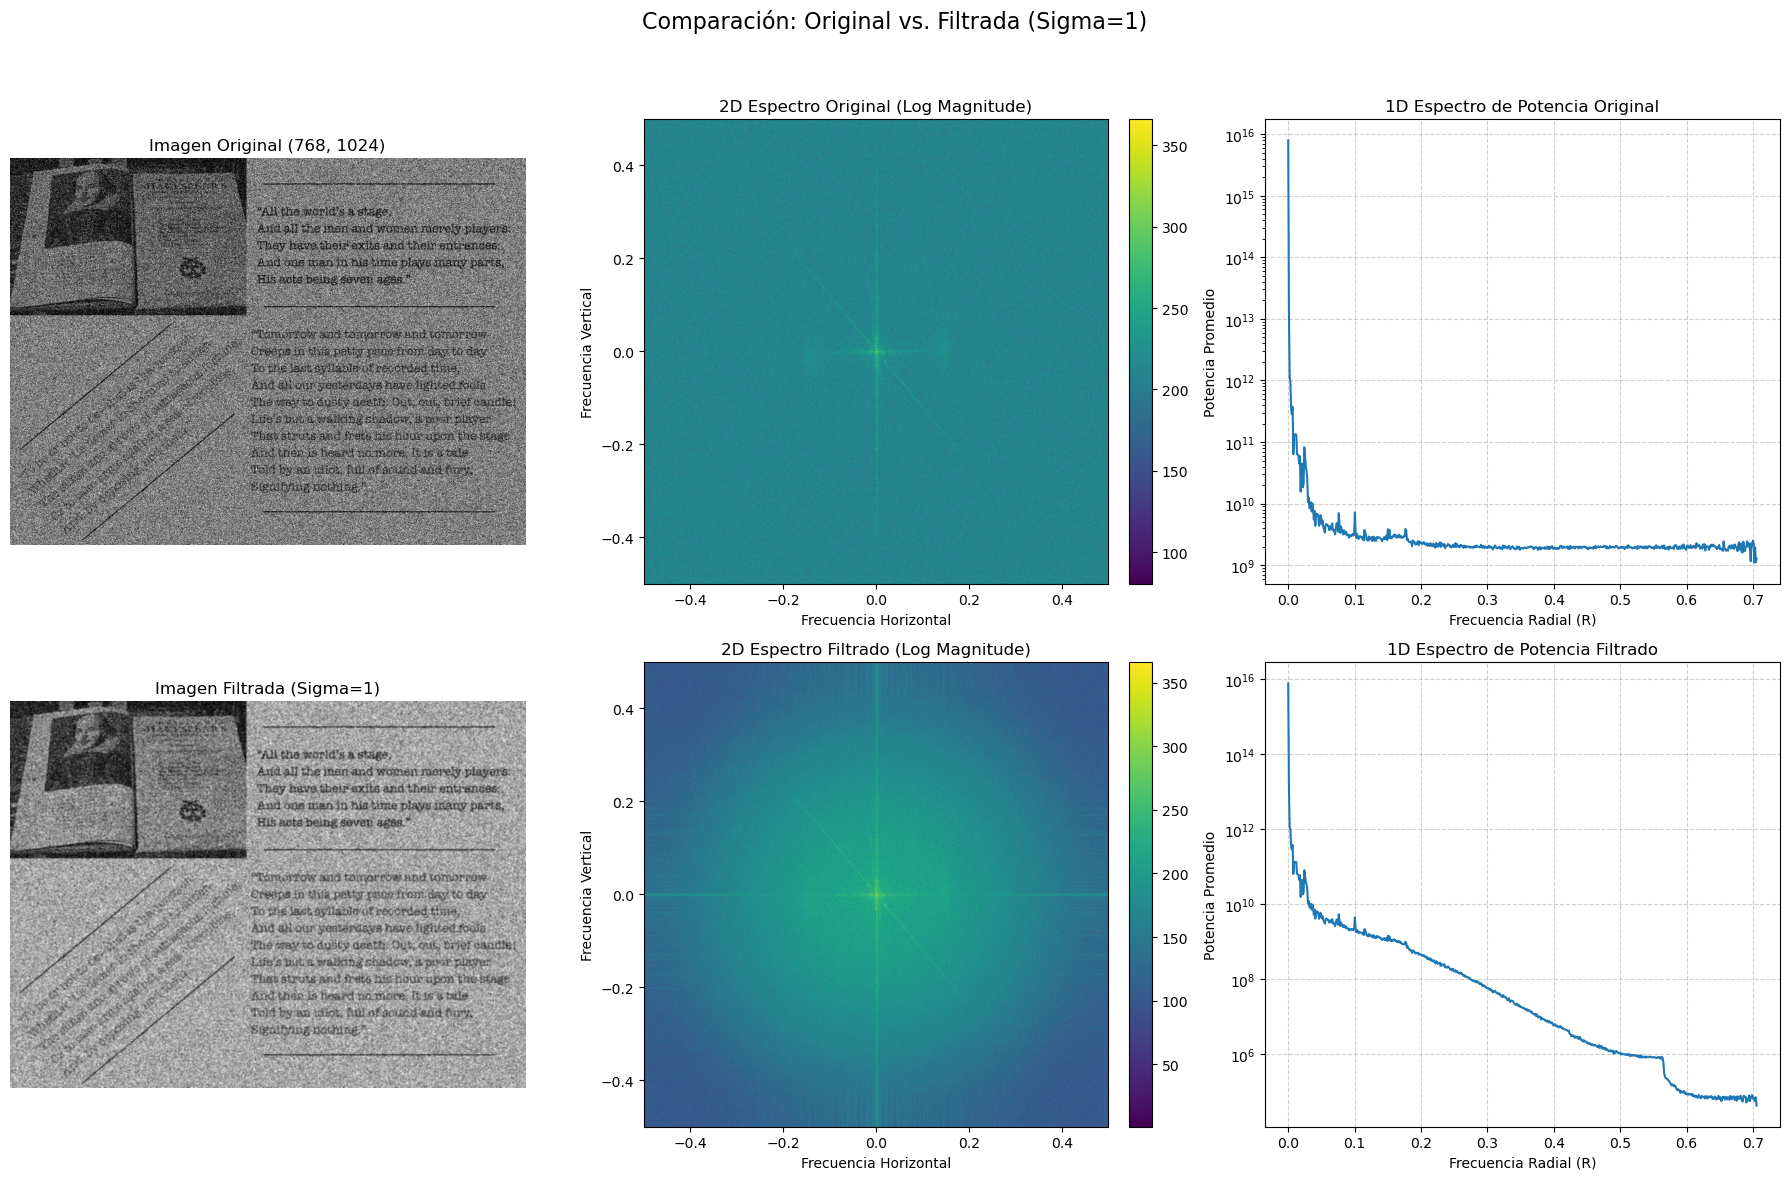

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter

# Asegúrate de que las bibliotecas están instaladas:
# pip install numpy matplotlib scipy

def PowerSpectrum1D(power_spectrum_2D):
    """
    Calcula el perfil radial promediando los valores de potencia a la misma
    distancia (radio) del centro en el espectro 2D.
    """
    M, N = power_spectrum_2D.shape
    center_y, center_x = M // 2, N // 2
    y, x = np.indices(power_spectrum_2D.shape)
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    r_int = r.astype(int)
    
    # Suma del Espectro de Potencia para cada radio
    pbin = np.bincount(r_int.ravel(), power_spectrum_2D.ravel()) 
    # Número de píxeles con cierto radio
    nr = np.bincount(r_int.ravel()) 
    
    # Calcula el promedio (Espectro 1D)
    profile = pbin / np.where(nr == 0, 1, nr) 
    
    max_radius = np.max(r_int)
    return profile[:max_radius]

def calculate_spectra(gray_img):
    """
    Calcula el Espectro 2D (con logaritmo) y el Espectro 1D a partir de una imagen en escala de grises.
    """
    f = np.fft.fft2(gray_img)
    fshift = np.fft.fftshift(f)
    
    # Espectro 2D
    power_spectrum_2D = np.abs(fshift)**2 
    # Espectro 2D en escala logarítmica para visualización
    power_spectrum_2D_log = 20 * np.log(np.abs(fshift)) 
    
    # Espectro de Potencia 1D
    power_spectrum_1D = PowerSpectrum1D(power_spectrum_2D)
    
    return power_spectrum_2D_log, power_spectrum_1D

def apply_gaussian_filter(gray_img, sigma):
    """
    Aplica un filtro Gaussiano a la imagen en escala de grises.
    El parámetro 'sigma' controla el grado de suavizado (desviación estándar del kernel Gaussiano).
    """
    # 
    filtered_img = gaussian_filter(gray_img, sigma=sigma)
    return filtered_img

def plot_comparison(image_path, sigma=3):
    """
    Carga una imagen, aplica un filtro Gaussiano y grafica:
    1. Imagen Original y su 2D/1D Espectro de Potencia.
    2. Imagen Filtrada y su 2D/1D Espectro de Potencia.
    """
    
    img = mpimg.imread(image_path) 
    
    # Convertir a escala de grises
    if img.ndim == 3:
        gray_img = np.mean(img[:, :, :3], axis=2) 
    elif img.ndim == 2:
        gray_img = img

    # 1. Calcular espectros de la imagen ORIGINAL
    ps_2d_log_orig, ps_1d_orig = calculate_spectra(gray_img)
    
    # 2. Aplicar filtro Gaussiano
    filtered_img = apply_gaussian_filter(gray_img, sigma=sigma)
    
    # 3. Calcular espectros de la imagen FILTRADA
    ps_2d_log_filt, ps_1d_filt = calculate_spectra(filtered_img)

    # Configuración de ejes de frecuencia para los espectros 2D y 1D
    M, N = gray_img.shape
    freq_x = np.fft.fftshift(np.fft.fftfreq(N))
    freq_y = np.fft.fftshift(np.fft.fftfreq(M)) 
    
    max_radius = len(ps_1d_orig)
    max_freq = np.sqrt(freq_x.max()**2 + freq_y.max()**2) 
    radial_freqs = np.linspace(0, max_freq, max_radius)

    
    # --- PLOTTEO DE COMPARACIÓN ---
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Comparación: Original vs. Filtrada (Sigma={sigma})', fontsize=16)

    # Fila 1: Imagen Original y sus Espectros
    
    # Plot 1.1: Imagen Original
    axes[0, 0].imshow(gray_img, cmap='gray')
    axes[0, 0].set_title(f'Imagen Original {gray_img.shape}', fontsize=12)
    axes[0, 0].axis('off')

    # Plot 1.2: 2D Spectrum Original
    im_orig = axes[0, 1].imshow(ps_2d_log_orig, cmap='viridis', extent=[freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max()])
    axes[0, 1].set_title('2D Espectro Original (Log Magnitude)', fontsize=12)
    axes[0, 1].set_xlabel('Frecuencia Horizontal')
    axes[0, 1].set_ylabel('Frecuencia Vertical')
    plt.colorbar(im_orig, ax=axes[0, 1], fraction=0.046, pad=0.04)

    # Plot 1.3: 1D Power Spectrum Original
    axes[0, 2].plot(radial_freqs, ps_1d_orig)
    axes[0, 2].set_title('1D Espectro de Potencia Original', fontsize=12)
    axes[0, 2].set_xlabel('Frecuencia Radial (R)')
    axes[0, 2].set_ylabel('Potencia Promedio')
    axes[0, 2].set_yscale('log')
    axes[0, 2].grid(True, linestyle='--', alpha=0.6)
    
    # Fila 2: Imagen Filtrada y sus Espectros

    # Plot 2.1: Imagen Filtrada
    axes[1, 0].imshow(filtered_img, cmap='gray')
    axes[1, 0].set_title(f'Imagen Filtrada (Sigma={sigma})', fontsize=12)
    axes[1, 0].axis('off')

    # Plot 2.2: 2D Spectrum Filtrado
    im_filt = axes[1, 1].imshow(ps_2d_log_filt, cmap='viridis', extent=[freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max()])
    axes[1, 1].set_title('2D Espectro Filtrado (Log Magnitude)', fontsize=12)
    axes[1, 1].set_xlabel('Frecuencia Horizontal')
    axes[1, 1].set_ylabel('Frecuencia Vertical')
    plt.colorbar(im_filt, ax=axes[1, 1], fraction=0.046, pad=0.04)

    # Plot 2.3: 1D Power Spectrum Filtrado
    axes[1, 2].plot(radial_freqs, ps_1d_filt)
    axes[1, 2].set_title('1D Espectro de Potencia Filtrado', fontsize=12)
    axes[1, 2].set_xlabel('Frecuencia Radial (R)')
    axes[1, 2].set_ylabel('Potencia Promedio')
    axes[1, 2].set_yscale('log')
    axes[1, 2].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- EJECUCIÓN DE LA FUNCIÓN DE COMPARACIÓN ---

# Nota: He comentado las ejecuciones de la función 'plot' original para usar la nueva.
# La función 'plot' original queda obsoleta con esta nueva función de comparación.

#plot_comparison('Images/eso_ngc1187.jpg', sigma=5)
plot_comparison('Images/img_sms_1_noisy.jpg', sigma=1)
#plot_comparison('Images/JWST_smacs0723.jpg', sigma=4)
# plot('Images/hst_abell370_grey.jpg')
# plot('Images/hst_abell370.png')
# plot('Images/img_sms_2.jpeg')
# plot('Images/abs.jpeg')